# Libraries

In [62]:
import numpy as np
import scipy
from scipy import signal
import matplotlib.pyplot as plt
from pathlib import Path
import sys

root = str(Path().resolve().parent)
if root not in sys.path:
    sys.path.append(root)
print(*sys.path, sep="\n")

%matplotlib ipympl
# %matplotlib inline

/usr/lib/python312.zip
/usr/lib/python3.12
/usr/lib/python3.12/lib-dynload

/home/ryanwtsai/repos/rfdsp_sim/python/venv/lib/python3.12/site-packages
/home/ryanwtsai/repos/rfdsp_sim/python


In [69]:
from importlib import reload
from rfdsppy import calc, ofdm, rf_analog, rf_tx_fw, tonegen, digital_filter_design, digital_hw_algo as dighw

reload(calc)
reload(ofdm)
reload(rf_analog)
reload(rf_tx_fw)
reload(tonegen)
reload(digital_filter_design)
reload(dighw)

<module 'rfdsppy.digital_hw_algo' from '/home/ryanwtsai/repos/rfdsp_sim/python/rfdsppy/digital_hw_algo.py'>

# Downsampling

Fs, in: 184.32 MHz


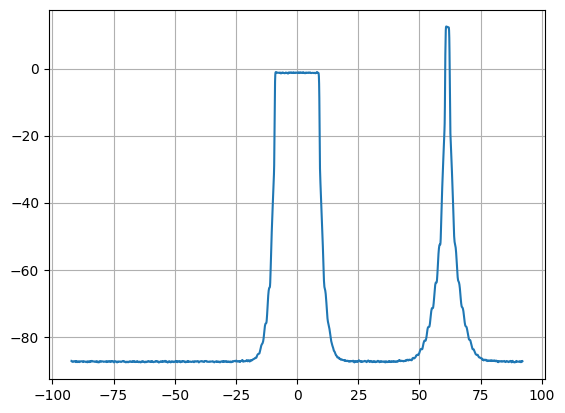

In [35]:
# Generate waveforms

R = 3 # Downsample by 3
pdelta = 3 # Power delta in dB for downsampling example (blocker minus desired)

# Desired signal
nsym = 14*10
modorder = 4
bw = 20
scs = 15
num_sc = 1200
start_sc = 600-round(num_sc/2)
en_tprecode = False
osr = R*2
wola = 1
sig_frac_bits = 15
sig_power = -19
sig_wg = ofdm.OFDMWavGen(bw, scs, modorder, start_sc, num_sc=num_sc, en_tprecode=en_tprecode, osr=osr, wola=wola, bitwidth=sig_frac_bits+1, power=sig_power)

x_signal, x_standard = sig_wg.generate(nsym)
cfg = sig_wg.get_demod_params()
fs_in = cfg.get("fs")
print(f"Fs, in: {fs_in} MHz")

# Blocker
num_sc_block = 100
start_sc_block = round((100*12-num_sc_block)/2)
block_wg = ofdm.OFDMWavGen(bw, scs, modorder, start_sc_block, num_sc=num_sc_block, en_tprecode=en_tprecode, osr=osr, wola=wola, bitwidth=sig_frac_bits+1, power=sig_power+pdelta)
x_blocker, _ = block_wg.generate(nsym)
w_blocker = 2*np.pi/R
x_blocker = x_blocker*np.exp(1j*w_blocker*np.arange(x_blocker.size)) # Frequency shift blocker to correct location

# Add signal and blocker
x = x_signal+x_blocker

p, f = calc.psd(x, fs_in, fs_in/2048)
fig, axs = plt.subplots(dpi=100)
axs.plot(f, 10*np.log10(p))
axs.grid()

digital_filter_design.firls_rate_change()
Largest passband ripple (dB) = 0.0
Smallest stopband rejection (dB) = 123.9



[    2    10    16   -16  -111  -165    62   599   837  -151 -2223 -3120
   249  8450 17552 21552 17552  8450   249 -3120 -2223  -151   837   599
    62  -165  -111   -16    16    10     2]

[[    2   -16    62  -151   249 21552   249  -151    62   -16     2]
 [   10  -111   599 -2223  8450 17552 -3120   837  -165    16     0]
 [   16  -165   837 -3120 17552  8450 -2223   599  -111    10     0]]


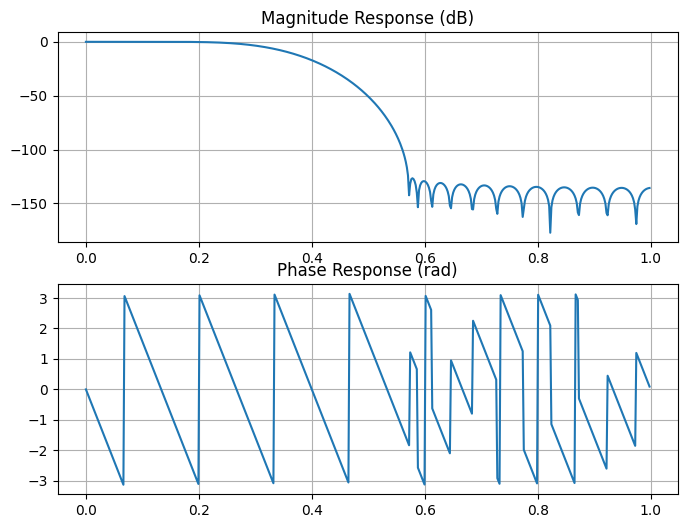

In [55]:
ntaps = 31
obw = num_sc*scs/1000
b = digital_filter_design.firls_rate_change('down', ntaps, obw, fs_in, R, en_plot=True)
b = b/b.sum()

b_pp = dighw.polyphase_decomposition(b, R)
# b_pp = dighw.polyphase_decomposition(b, R, mode="symmetric")

print(np.round(b*2**16).astype("int"))
print("")
print(np.round(b_pp*2**16).astype("int"))

In [70]:
polydown = dighw.PolyphaseDownsampler(b_pp, decomp_type="conventional")

np.complex128(-66.6820408742285+18.223934343821043j)

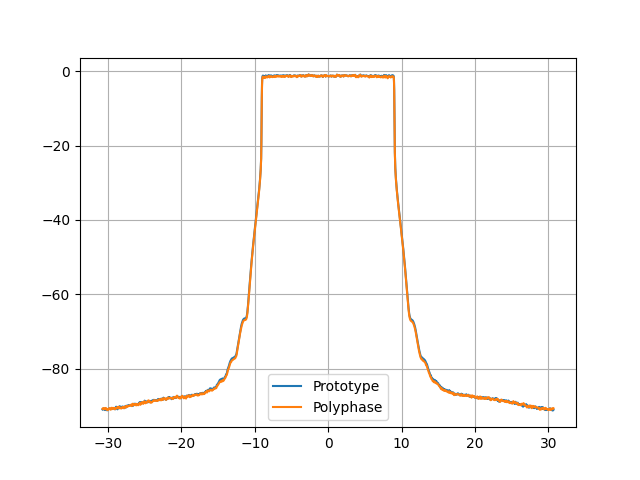

In [71]:
# Filter using the prototype filter
y_prototype = signal.lfilter(b, 1, x)
y_prototype_down = dighw.downsample(y_prototype, R)
# y_prototype_down = dighw.downsample(x, R) # no filtering

# Filter using the polyphase filter
# y_polyphase = dighw.polyphase_downsampler(x, b, R, frac_bits)
y_polyphase = polydown.transform(x)

fig, axs = plt.subplots(dpi=100)

p, f = calc.psd(y_prototype_down, fs_in/R, fs_in/R/2048)
axs.plot(f,10*np.log10(p), label="Prototype")

p, f = calc.psd(y_polyphase, fs_in/R, fs_in/R/2048)
axs.plot(f,10*np.log10(p), label="Polyphase")
axs.grid()
axs.legend(loc="lower center")

min_len = np.min((y_polyphase.size, y_prototype_down.size))
e = y_polyphase[:min_len]-y_prototype_down[:min_len]
np.sum(e)

In [59]:
y_prototype_down.shape
# y_polyphase.shape

(613615,)

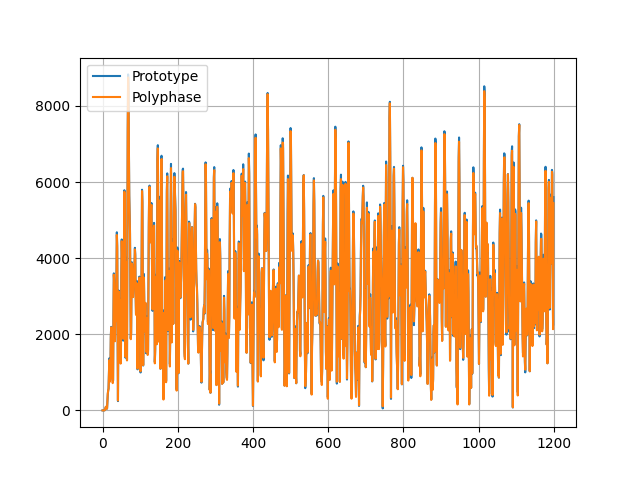

In [72]:
fig, ax = plt.subplots(dpi=100)

mdx = 1200
ax.plot(np.abs(y_prototype_down)[:mdx], label="Prototype")
ax.plot(np.abs(y_polyphase)[:mdx], label="Polyphase")
ax.grid()
ax.legend(loc="upper left")

In [54]:
cfg.get("wola_len")

124

In [67]:
x_signal.size
y_restored.size

1840842

In [80]:
1840811-1840842

-31

1840811


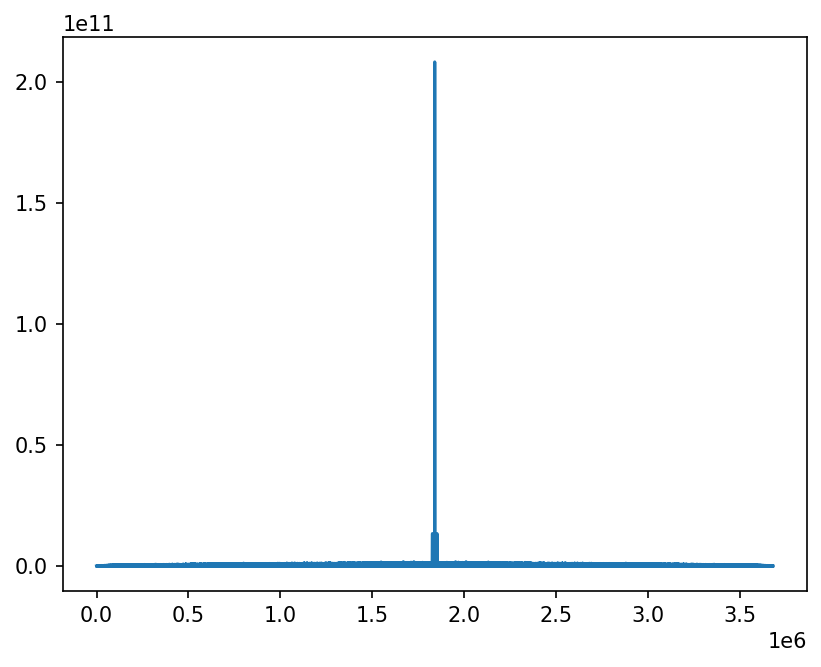

In [79]:
# corr = signal.correlate(x_signal, y_restored)
corr = signal.correlate(y_restored, x_standard)
fig, axs = plt.subplots(dpi=150)
axs.plot(np.abs(corr))
print(np.abs(corr).argmax())

EVM: 0.14
SNR: 57.08


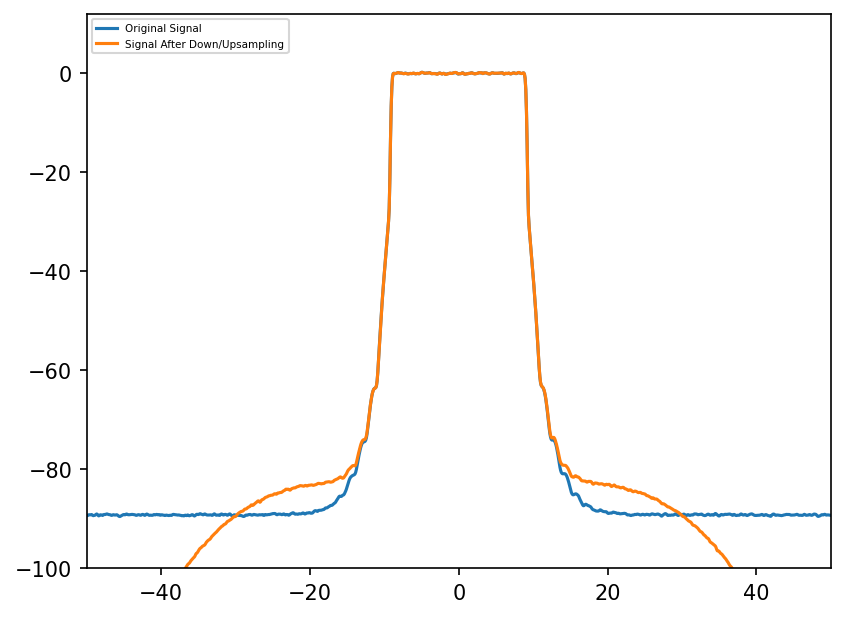

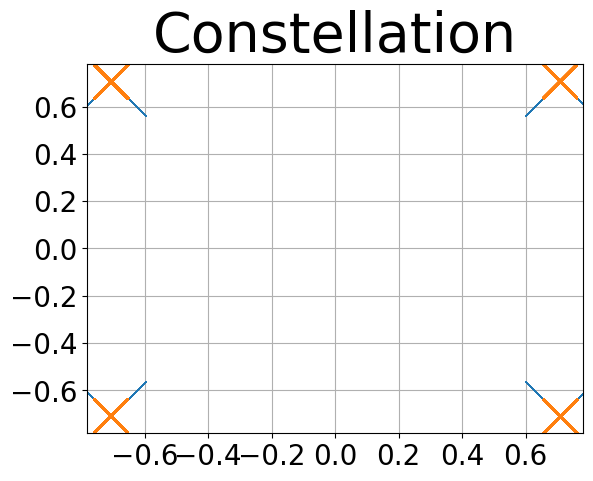

In [ ]:
y_restored = dighw.upsample(y_polyphase, R)
y_restored = signal.lfilter(b, 1, y_restored)

fig, axs = plt.subplots(dpi=150)

p, f = calc.psd(x_signal, fs_in, fs_in/2048)
p = calc.scale_psd(p, f, bw, scs, start_sc, num_sc)
axs.plot(f,10*np.log10(p), label="Original Signal")

p, f = calc.psd(y_restored, fs_in, fs_in/2048)
p = calc.scale_psd(p, f, bw, scs, start_sc, num_sc)
axs.plot(f,10*np.log10(p), label="Signal After Down/Upsampling")
axs.legend(loc="upper left", fontsize=5)
axs.set_ylim(bottom=-100)
axs.set_xlim(left=-50, right=50)

# evm = sig_wg.calculate_evm(x_standard, y_restored[round(cfg.get("wola_len")/2):], en_plot=True)
# For some reason there is phase error that needs to be equalized
evm = sig_wg.calculate_evm(x_standard, y_restored[31+round(cfg.get("wola_len")/2):], en_plot=True, en_fd_eq=True)
snr = round(-20*np.log10(evm/100),2)
print(f"EVM: {evm.round(2)}")
print(f"SNR: {snr}")